# Análisis Exploratorio del Dataset MVTec AD - Clase Cable
Este notebook realiza un análisis exploratorio básico del conjunto de datos MVTec AD para la clase "cable".
Se incluyen estadísticas descriptivas, conteo de imágenes normales y defectuosas, y visualización de ejemplos.

## Carga de librerías y configuración

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google.colab import files
import cv2
import random
import glob
from collections import Counter

In [2]:
# Ruta al dataset
DATA_DIR = "/content/mvtec_dataset/cable"

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Carga de datos

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juliagarve","key":"5649c5612324fd329c47d1502707613b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ipythonx/mvtec-ad
!mkdir -p mvtec_dataset
!unzip -q mvtec-ad.zip -d mvtec_dataset/

Dataset URL: https://www.kaggle.com/datasets/ipythonx/mvtec-ad
License(s): copyright-authors
100% 4.88G/4.91G [00:58<00:00, 273MB/s]
100% 4.91G/4.91G [00:58<00:00, 90.1MB/s]


In [5]:
# Carpetas principales
train_dir = os.path.join(DATA_DIR, "train", "good")
test_dir = os.path.join(DATA_DIR, "test")
ground_truth_dir = os.path.join(DATA_DIR, "ground_truth")

def list_images(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".png")]

## Exploración inicial

### Cantidad y distribución de clases

In [6]:
# Imágenes de entrenamiento (solo normales)
train_images = list_images(train_dir)
print(f"Número de imágenes de entrenamiento (normales): {len(train_images)}")

Número de imágenes de entrenamiento (normales): 224


In [7]:
# Subcarpetas en test (tipos de defecto)
test_subfolders = [f for f in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, f))]
print("Subcarpetas en test (tipos de defecto):")
for i, sub in enumerate(test_subfolders, 1):
    print(f"  {i}. {sub}")

defect_classes = [cls for cls in test_subfolders if cls != "good"]

Subcarpetas en test (tipos de defecto):
  1. combined
  2. good
  3. poke_insulation
  4. cut_outer_insulation
  5. cut_inner_insulation
  6. missing_cable
  7. cable_swap
  8. missing_wire
  9. bent_wire


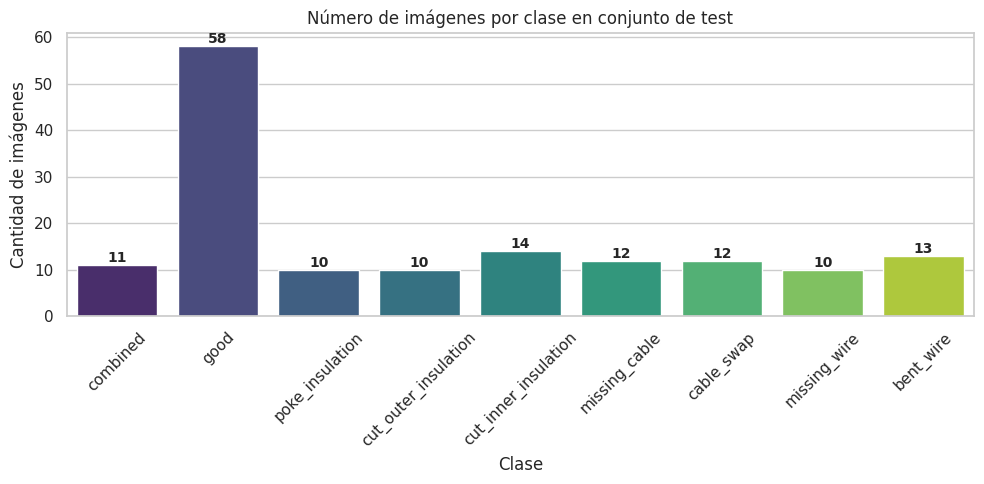

In [8]:
# Contar imágenes por tipo en test
test_image_counts = {}
for sub in test_subfolders:
    folder = os.path.join(test_dir, sub)
    imgs = list_images(folder)
    test_image_counts[sub] = len(imgs)

# Convertir los datos a DataFrame
df_test_counts = pd.DataFrame({
    "Clase": list(test_image_counts.keys()),
    "Cantidad": list(test_image_counts.values())
})

# Visualización con seaborn
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_test_counts, x="Clase", y="Cantidad", hue="Clase", dodge=False, palette="viridis", legend=False)

# Añadir valores encima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Número de imágenes por clase en conjunto de test")
plt.ylabel("Cantidad de imágenes")
plt.xlabel("Clase")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Tamaños de imagen

Estadísticas de dimensiones de imagen (train + test):
        Width  Height
count   374.0   374.0
mean   1024.0  1024.0
std       0.0     0.0
min    1024.0  1024.0
25%    1024.0  1024.0
50%    1024.0  1024.0
75%    1024.0  1024.0
max    1024.0  1024.0


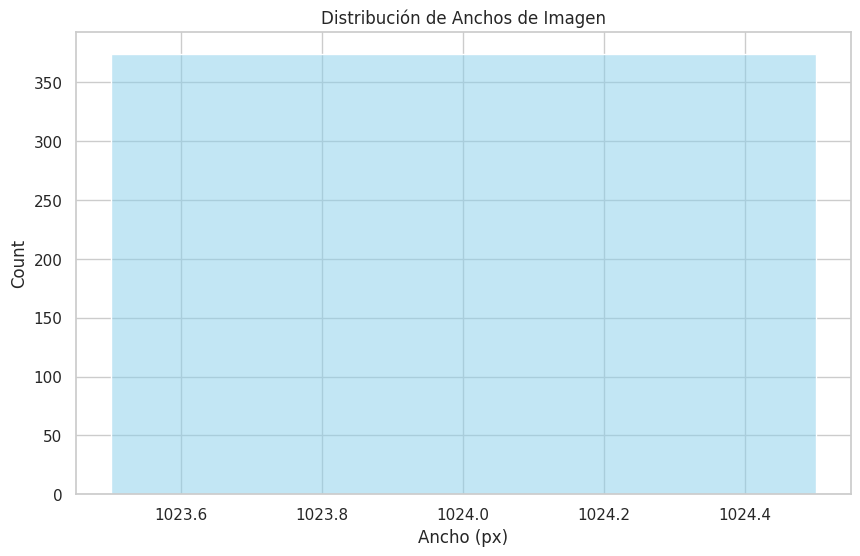

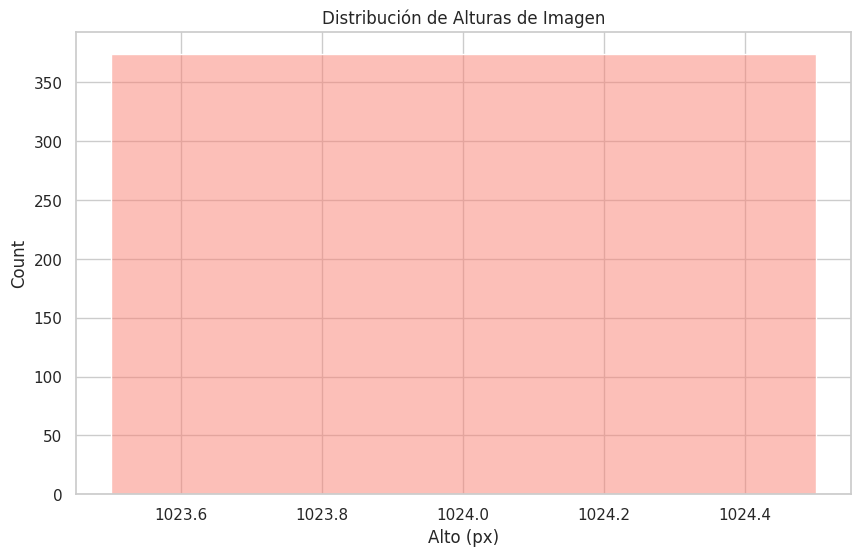

In [ ]:
image_shapes = []

for fname in os.listdir(train_dir):
    img_path = os.path.join(train_dir, fname)
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')): continue
    with Image.open(img_path) as img:
        image_shapes.append(img.size)

# Extraer tamaños de imágenes de test
test_dir = os.path.join(DATA_DIR, "test")
test_subfolders = [f for f in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, f))]

for defect_type in test_subfolders:
    defect_path = os.path.join(test_dir, defect_type)
    for fname in os.listdir(defect_path):
        img_path = os.path.join(defect_path, fname)
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')): continue
        with Image.open(img_path) as img:
            image_shapes.append(img.size)

# Crear DataFrame y mostrar estadísticas
shapes_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
print("Estadísticas de dimensiones de imagen (train + test):")
print(shapes_df.describe())

# Visualizaciones
sns.histplot(data=shapes_df, x='Width', kde=True, color='skyblue')
plt.title('Distribución de Anchos de Imagen')
plt.xlabel('Ancho (px)')
plt.show()

sns.histplot(data=shapes_df, x='Height', kde=True, color='salmon')
plt.title('Distribución de Alturas de Imagen')
plt.xlabel('Alto (px)')
plt.show()

### Visualizaciones

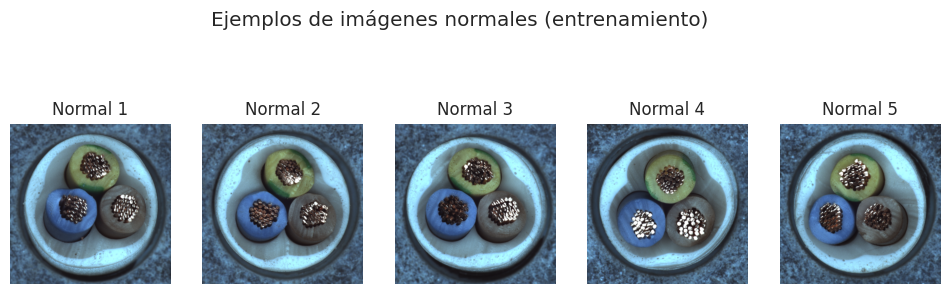

In [ ]:
# Visualización de algunas imágenes normales
plt.figure(figsize=(12, 4))
for i, img_path in enumerate(train_images[:5]):
    with Image.open(img_path) as img:
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Normal {i+1}")
        plt.axis("off")
plt.suptitle("Ejemplos de imágenes normales (entrenamiento)")
plt.show()

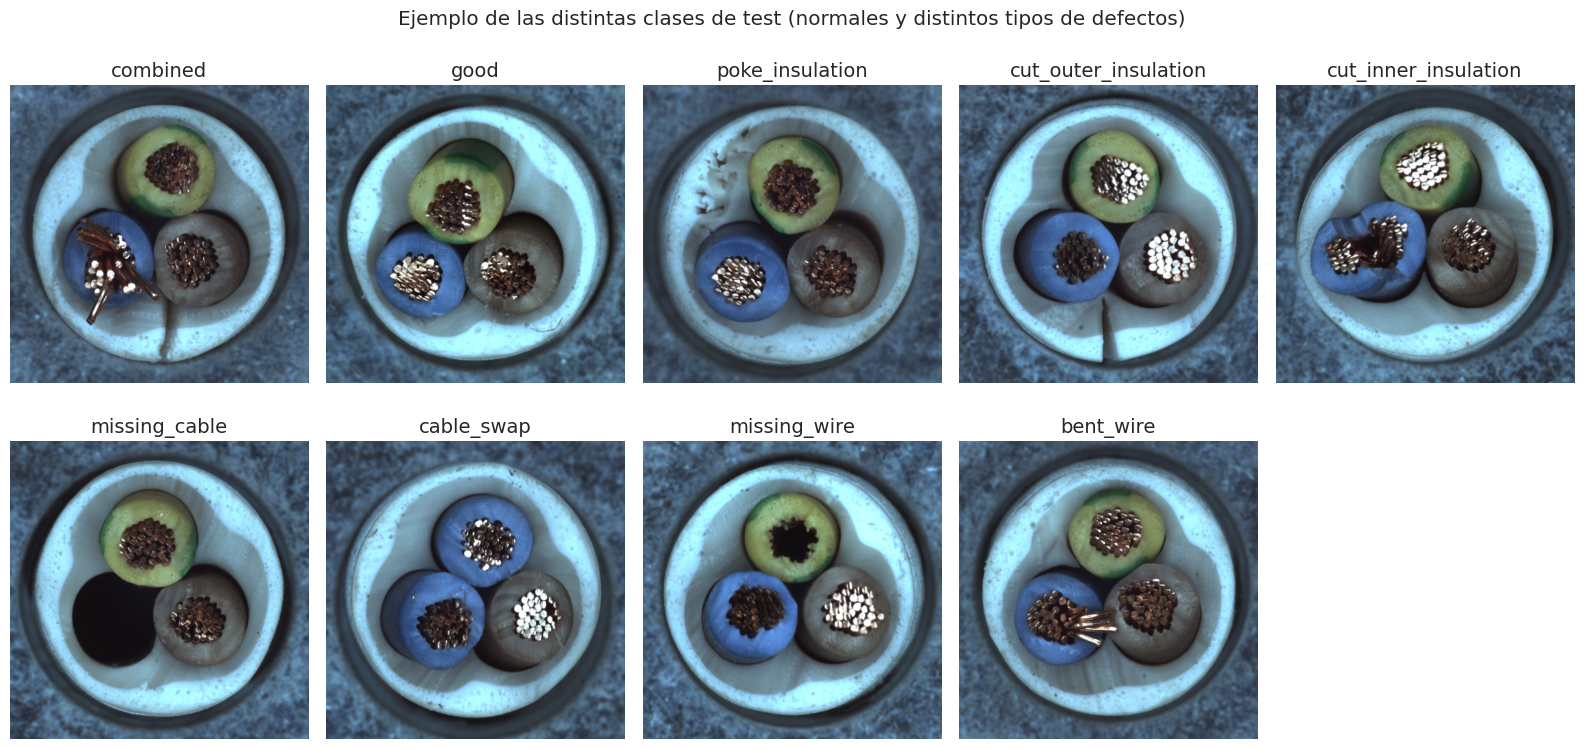

In [10]:
# Visualización de ejemplos de defectos (test)
plt.figure(figsize=(16, 8))

idx = 1
for defect_type in test_subfolders:
    defect_path = os.path.join(test_dir, defect_type)
    image_files = glob.glob(os.path.join(defect_path, "*.png"))

    if len(image_files) > 0:
        with Image.open(image_files[0]) as img:
            plt.subplot(2, len(test_subfolders)//2 + 1, idx)
            plt.imshow(img)
            plt.title(defect_type, fontsize=14)
            plt.axis("off")
            idx += 1

plt.suptitle("Ejemplo de las distintas clases de test (normales y distintos tipos de defectos)")
plt.tight_layout()
plt.show()

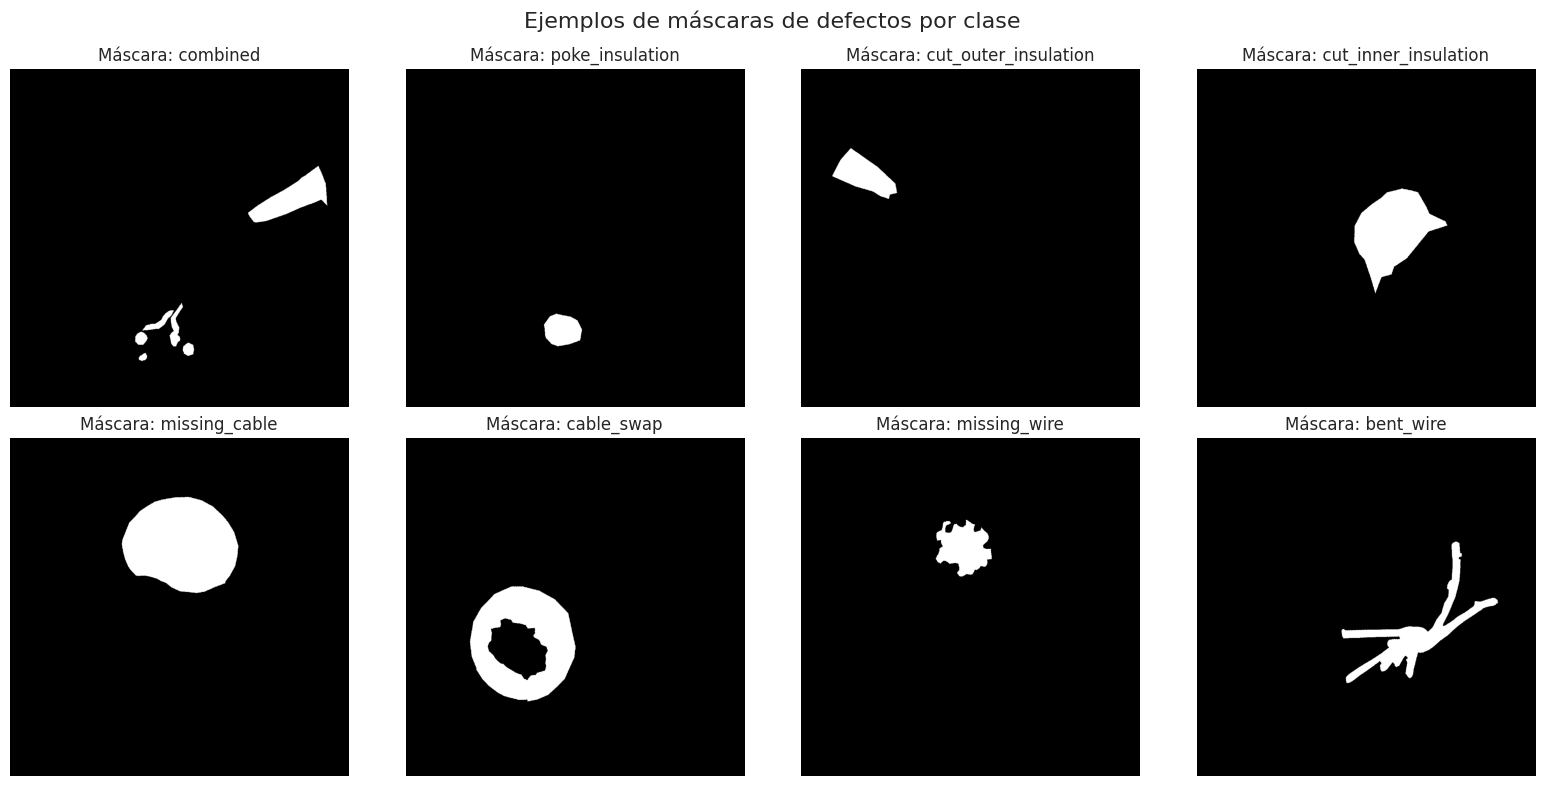

In [9]:
cols = 4
rows = 2
# Mostrar ejemplos de máscaras
plt.figure(figsize=(4 * cols, 4 * rows))
for idx, cls in enumerate(defect_classes):
    mask_dir = os.path.join(ground_truth_dir, cls)
    paths = list_images(mask_dir)
    if paths:
        mask = np.array(Image.open(random.choice(paths)).convert("L"))
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Máscara: {cls}")
        plt.axis("off")
plt.suptitle("Ejemplos de máscaras de defectos por clase", fontsize=16)
plt.tight_layout()
plt.show()

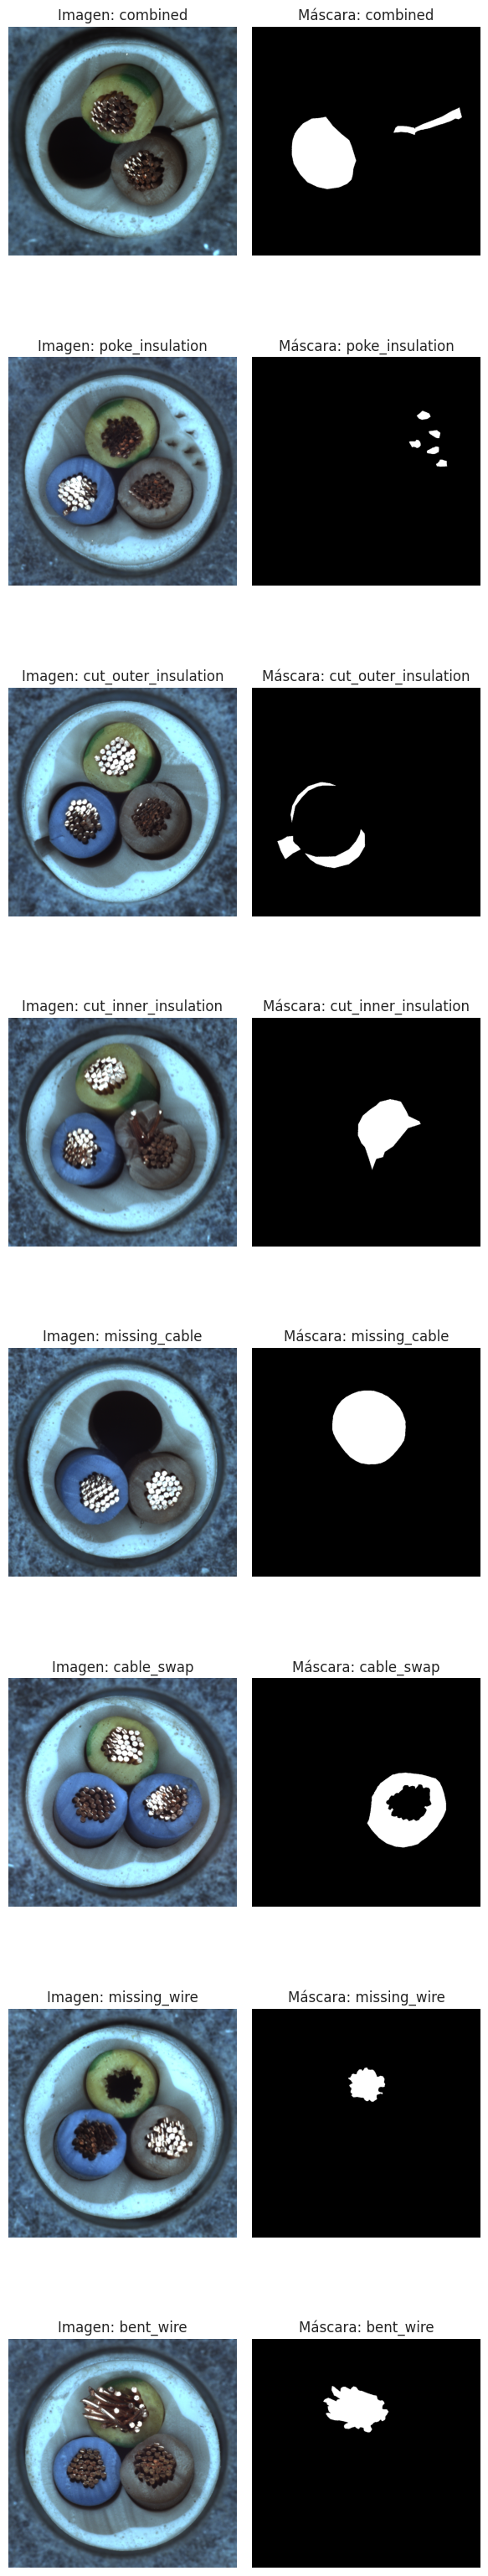

In [35]:
# Imagen + Máscara
cols = 2
rows = len(defect_classes)  # Una fila por clase

plt.figure(figsize=(3 * cols, 4 * rows))
subplot_idx = 1

for cls in defect_classes:
    image_dir = os.path.join(test_dir, cls)
    mask_dir = os.path.join(ground_truth_dir, cls)

    # Obtener rutas de imágenes y máscaras
    image_paths = sorted(list_images(image_dir))
    mask_paths = sorted(list_images(mask_dir))

    # Crear diccionario de máscaras con clave el nombre base sin _mask
    mask_dict = {
        os.path.basename(f).replace("_mask.png", ""): f
        for f in mask_paths if f.endswith("_mask.png")
    }

    # Emparejar imágenes con sus máscaras
    paired = []
    for img_path in image_paths:
        base_name = os.path.basename(img_path).replace(".png", "")
        if base_name in mask_dict:
            paired.append((img_path, mask_dict[base_name]))

    if not paired:
        print(f"[AVISO] No hay pares imagen-máscara para clase: {cls}")
        continue

    # Seleccionar una pareja aleatoria
    img_path, mask_path = random.choice(paired)

    # Mostrar imagen
    img = Image.open(img_path)
    plt.subplot(rows, cols, subplot_idx)
    plt.imshow(img)
    plt.title(f"Imagen: {cls}")
    plt.axis("off")
    subplot_idx += 1

    # Mostrar máscara
    mask = Image.open(mask_path).convert("L")
    plt.subplot(rows, cols, subplot_idx)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Máscara: {cls}")
    plt.axis("off")
    subplot_idx += 1

plt.tight_layout()
plt.show()

### Análisis de intensidades

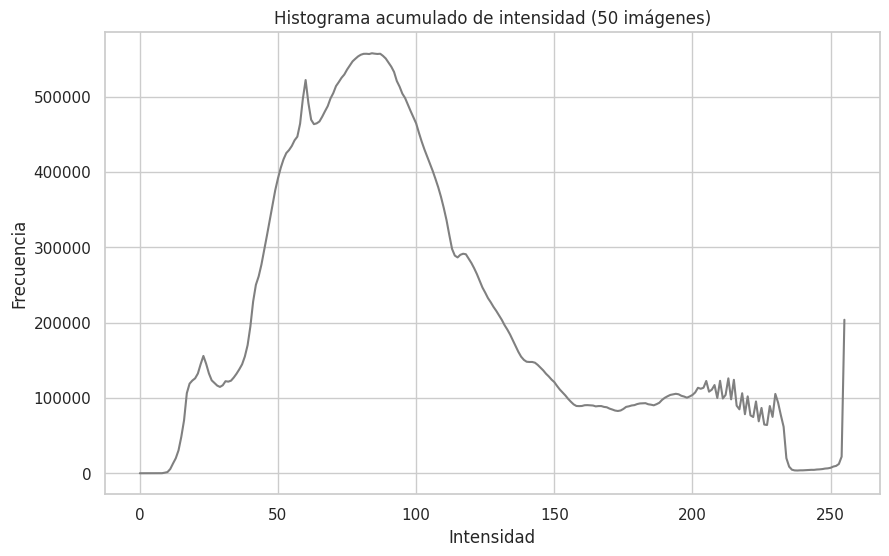

In [ ]:
# Análisis básico de píxeles: histograma de valores en imágenes normales
hist = np.zeros(256)

for img_path in train_images[:50]:
    with Image.open(img_path) as img:
        arr = np.array(img.convert("L"))
        h, _ = np.histogram(arr, bins=256, range=(0, 256))
        hist += h

plt.plot(range(256), hist, color='gray')
plt.title("Histograma acumulado de intensidad (50 imágenes)")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")
plt.show()

### Estadísticas de máscaras de anomalía


--- Estadísticas de Máscaras de Anomalía ---

Clase: combined
  Nº de máscaras: 11
  Área promedio: 66410.4 px
  Área mínima: 23893 px
  Área máxima: 148557 px

Clase: poke_insulation
  Nº de máscaras: 10
  Área promedio: 25058.8 px
  Área mínima: 1506 px
  Área máxima: 51028 px

Clase: cut_outer_insulation
  Nº de máscaras: 10
  Área promedio: 16147.1 px
  Área mínima: 4647 px
  Área máxima: 35537 px

Clase: cut_inner_insulation
  Nº de máscaras: 14
  Área promedio: 42511.6 px
  Área mínima: 19775 px
  Área máxima: 103750 px

Clase: missing_cable
  Nº de máscaras: 12
  Área promedio: 107644.6 px
  Área mínima: 69188 px
  Área máxima: 236776 px

Clase: cable_swap
  Nº de máscaras: 12
  Área promedio: 60773.2 px
  Área mínima: 51956 px
  Área máxima: 67894 px

Clase: missing_wire
  Nº de máscaras: 10
  Área promedio: 23131.8 px
  Área mínima: 15156 px
  Área máxima: 40701 px

Clase: bent_wire
  Nº de máscaras: 13
  Área promedio: 40446.8 px
  Área mínima: 12881 px
  Área máxima: 119231

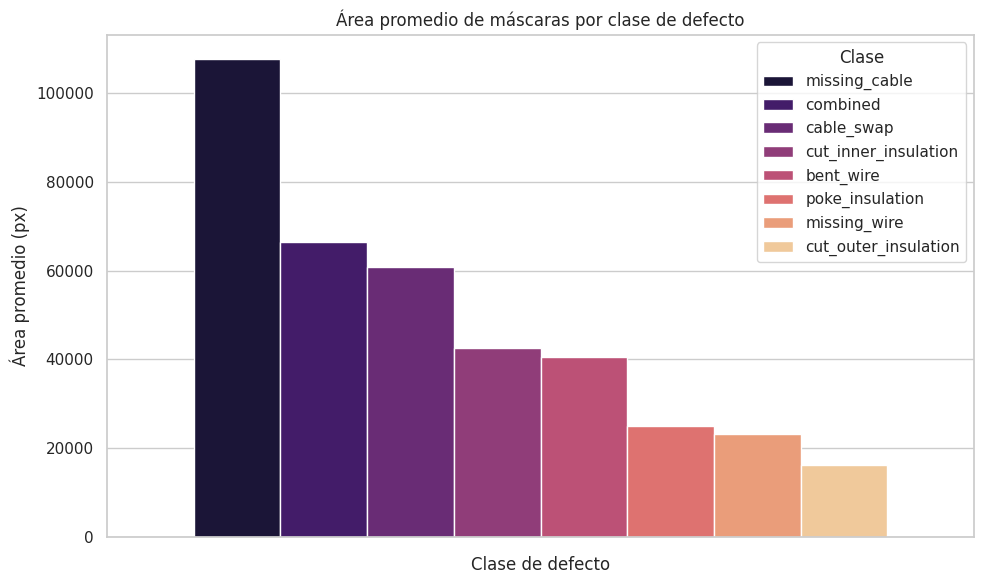

In [15]:
# Crear diccionario para almacenar estadísticas
mask_areas = {}
heatmaps = {}

for defect_class in defect_classes:
    mask_dir = os.path.join(ground_truth_dir, defect_class)
    mask_paths = list_images(mask_dir)

    areas = []
    acc_mask = None

    for path in mask_paths:
        mask = np.array(Image.open(path).convert("L"))  # Convertir a escala de grises
        mask_bin = (mask > 0).astype(np.uint8)  # Binarizar

        area = np.sum(mask_bin)
        areas.append(area)

        if acc_mask is None:
            acc_mask = mask_bin.astype(np.float32)
        else:
            acc_mask += mask_bin

    mask_areas[defect_class] = {
        "num_masks": len(mask_paths),
        "avg_area": np.mean(areas),
        "min_area": np.min(areas),
        "max_area": np.max(areas)
    }

    # Normalizar mapa de calor
    heatmap = acc_mask / len(mask_paths)
    heatmaps[defect_class] = heatmap

# Mostrar estadísticas
print("\n--- Estadísticas de Máscaras de Anomalía ---")
for cls, stats in mask_areas.items():
    print(f"\nClase: {cls}")
    print(f"  Nº de máscaras: {stats['num_masks']}")
    print(f"  Área promedio: {stats['avg_area']:.1f} px")
    print(f"  Área mínima: {stats['min_area']} px")
    print(f"  Área máxima: {stats['max_area']} px")

# Crear DataFrame a partir del diccionario de estadísticas
df_mask_areas = pd.DataFrame([
    {"Clase": cls, **stats}
    for cls, stats in mask_areas.items()
])

# Ordenar por área promedio descendente (opcional)
df_mask_areas = df_mask_areas.sort_values(by="avg_area", ascending=False)

# Gráfico de barras del área promedio por clase
plt.figure(figsize=(10, 6))
sns.barplot(data=df_mask_areas, hue="Clase", y="avg_area", palette="magma")

plt.title("Área promedio de máscaras por clase de defecto")
plt.xlabel("Clase de defecto")
plt.ylabel("Área promedio (px)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

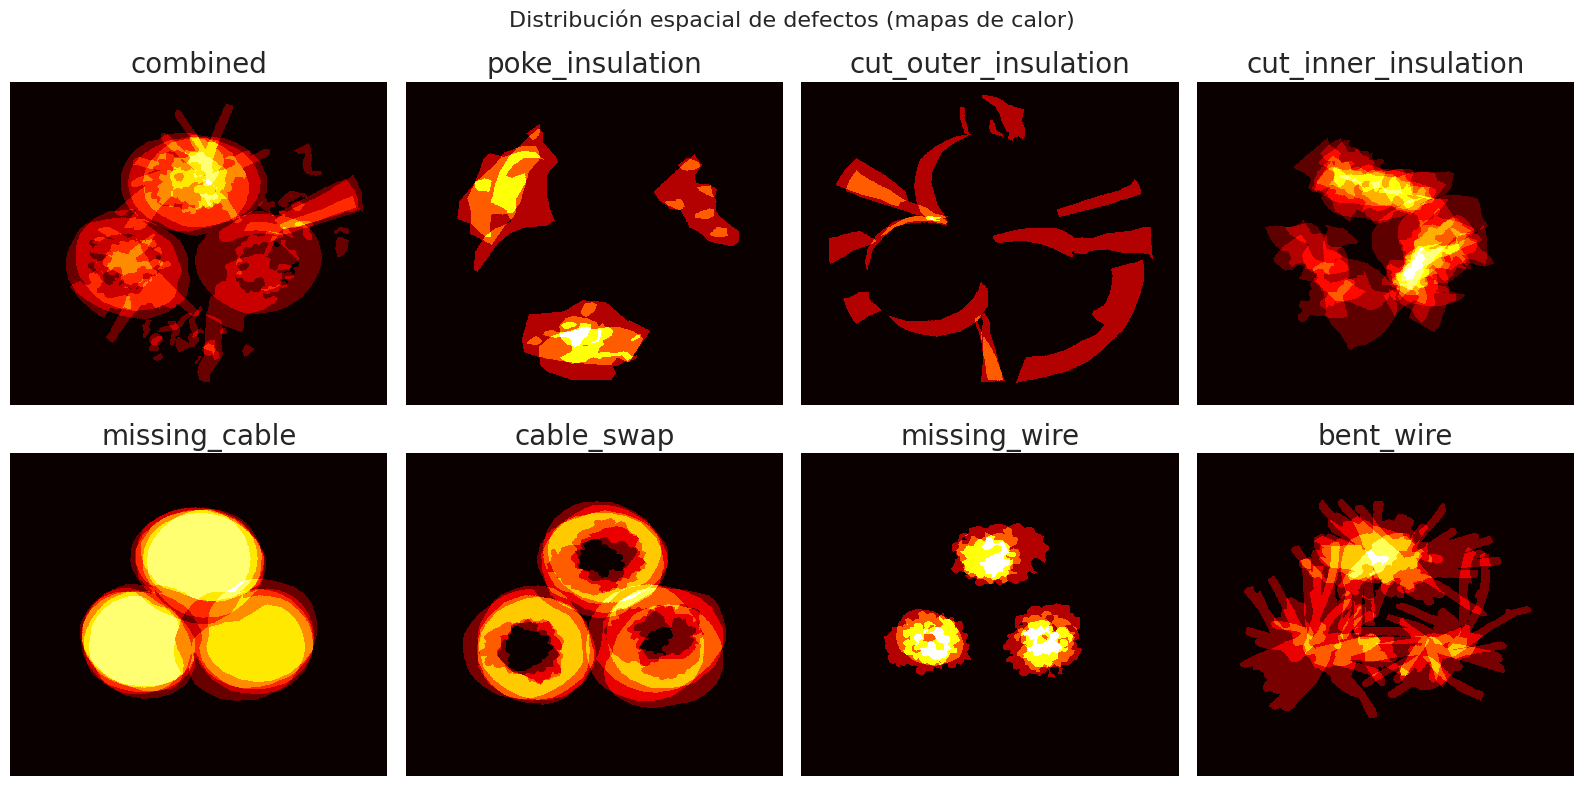

In [17]:
# Mostrar mapas de calor por clase
plt.figure(figsize=(4 * cols, 4 * rows))
for idx, cls in enumerate(defect_classes):
    plt.subplot(rows, cols, idx + 1)
    sns.heatmap(heatmaps[cls], cmap="hot", cbar=False)
    plt.title(cls, fontsize=20)
    plt.axis("off")
plt.suptitle("Distribución espacial de defectos (mapas de calor)", fontsize=16)
plt.tight_layout()
plt.show()